<a href="https://colab.research.google.com/github/starlingomez/preworkmac/blob/master/NBA_AST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trae Young

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 6.0 MB/s eta 0:00:00
Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301188   12   12    0    3    8    9    4     1     4    0    3    3   
1  0022301178   19    7    1    2    2   12    6     3     7    0    6    4   
2  0022301159   14   11    1    4    5    5    5     2     2    0    2    2   
3  0022300804   11    7    0    3    4   13    4     2     6    0    2    1   
4  0022300777   12   12    0    2    4   12    4     2     8    0    2    2   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0         -35           27       24       15       15          0  
1          16           28       26        9       21          1  
2          16           29       25       15       18          1  
3          -6           21       18       10       14          0  
4  

<ipython-input-1-f8a4287cf26d>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  25.0793
RMSE: 5.0079
R^2:  -0.4446


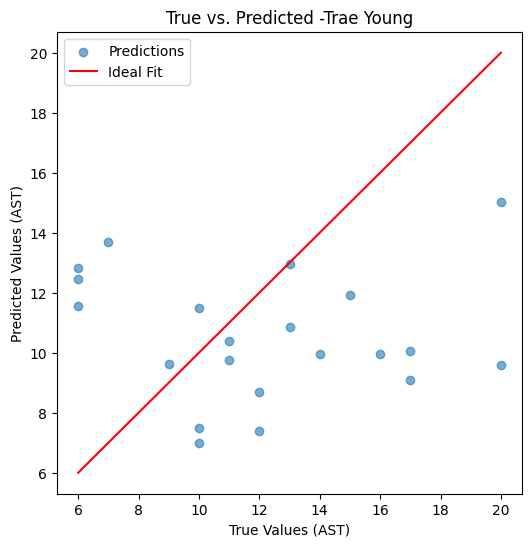


Using last 5-game averages for Trae Young:
   HOME   PTS  REB  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  27.2  1.8  0.8  5.8  19.0  8.4   3.2  10.2  0.0  8.2  7.2        -2.0

Predicted AST for Trae Young: 11.41
The model predicts that Trae Young  will go OVER 10.5 in today's game.


In [1]:
!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Trae Young's player ID
Jugador_id = players.find_players_by_full_name("Trae Young")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Trae Young.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'AST'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (AST)')
plt.ylabel('Predicted Values (AST)')
plt.title('True vs. Predicted -Trae Young')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 10.5  # Example threshold
print(f"\nUsing last 5-game averages for Trae Young:")
print(today_game_df)
print(f"\nPredicted AST for Trae Young: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Trae Young  will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Trae Young  will go UNDER {threshold} in today's game.")


#Amen Thompson

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301199   18   10    3   11    3    9    8     0     0    3    3    2   
1  0022301183   17    6    0   15    2   12    6     0     1    0    6    5   
2  0022301168   15    4    2   10    1   12    6     0     1    0    4    3   
3  0022301150   13    4    2    8    4    7    6     0     0    1    2    1   
4  0022301131    5    3    0    3    0    1    1     0     0    0    3    3   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0          12           39       28       21       29          6  
1          15           38       23       21       32          0  
2          -1           29       19       14       25          2  
3           1           25       17       12       21          3  
4          17           11        8        6        8          0  


<ipython-input-5-aaf0bc0ec216>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  5.4620
RMSE: 2.3371
R^2:  0.2368


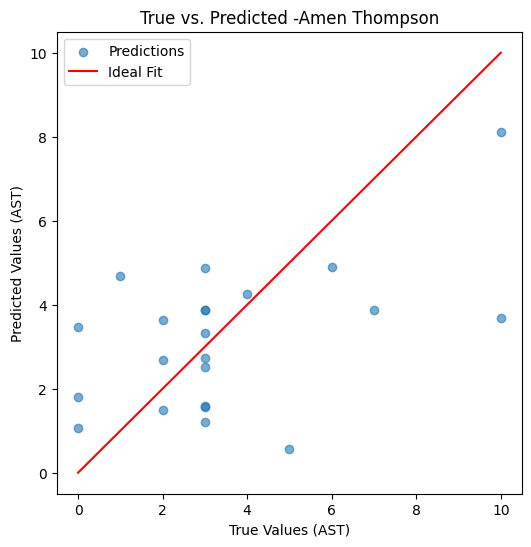


Using last 5-game averages for Amen Thompson:
   HOME   PTS  REB  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     0  14.4  7.8  2.2  2.6  11.8  5.0   0.0   0.8  1.8  5.2  4.4        -0.8

Predicted AST for Amen Thompson: 2.23
The model predicts that Amen Thompson will go UNDER 5.5 in today's game.


In [5]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Trae Young's player ID
Jugador_id = players.find_players_by_full_name("Amen Thompson")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Amen Thompson.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'AST'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (AST)')
plt.ylabel('Predicted Values (AST)')
plt.title('True vs. Predicted -Amen Thompson')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 0,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 5.5  # Example threshold
print(f"\nUsing last 5-game averages for Amen Thompson:")
print(today_game_df)
print(f"\nPredicted AST for Amen Thompson: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Amen Thompson  will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Amen Thompson will go UNDER {threshold} in today's game.")


#Rob Dillingham

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID PTS AST STL REB TOV FGA FGM FG3M FG3A BLK FTA FTM PLUS_MINUS  \
0  0022400723   3   3   1   3   0   6   1    1    2   0   0   0         -2   
1  0022400704   4   4   0   0   2   5   2    0    3   0   0   0         -6   
2  0022400690   7   7   1   3   2   8   3    0    3   0   2   1          0   
3  0022400677  19   8   1   0   4  11   8    3    5   0   1   0         23   
4  0022400672   8   3   0   2   1   4   3    0    0   0   2   2          3   

  PTS+REB+AST PTS+AST REB+AST PTS+REB BLKS+STLS  
0           9       6       6       6         1  
1           8       8       4       4         0  
2          17      14      10      10         1  
3          27      27       8      19         1  
4          13      11       5      10         0  

XGBRegressor Performance:
MSE:  2.8971
RMSE: 1.7021
R^2:  0.2387


<ipython-input-7-aa3a35c1498f>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(gamelogs, ignore_index=True)
<ipython-input-7-aa3a35c1498f>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])


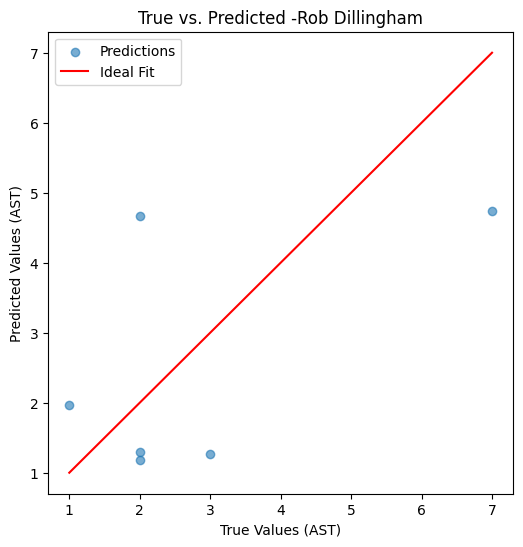


Using last 5-game averages for Rob Dillingham:
   HOME  PTS  REB  STL  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  8.2  1.6  0.6  1.8  6.8  3.4   0.8   2.6  0.0  1.0  0.6         3.6

Predicted AST for Rob Dillingham: 2.92
The model predicts that Rob Dillingham will go UNDER 3.5 in today's game.


In [7]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find TRob Dillingham's player ID
Jugador_id = players.find_players_by_full_name("Rob Dillingham")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Rob Dillingham.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'PTS', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'AST'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (AST)')
plt.ylabel('Predicted Values (AST)')
plt.title('True vs. Predicted -Rob Dillingham')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['PTS', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'PTS': avg_stats['PTS'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 3.5  # Example threshold
print(f"\nUsing last 5-game averages for Rob Dillingham:")
print(today_game_df)
print(f"\nPredicted AST for Rob Dillingham: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Rob Dillingham  will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Rob Dillingham will go UNDER {threshold} in today's game.")
